# Data Annotation

Sebelum dilakukan pelatihan model, dilakukan terlebih dahulu anotasi data pada dataset yang ditemukan. Dataset yang digunakan pada fitur rekomendasi ini ialah dataset fashionoutfititems yang dapat diakses melalui link berikut: https://www.kaggle.com/datasets/kritanjalijain/fashionoutfititems.

Dataset ini terdiri dari 48.8k gambar yang dibagi menjadi 5 kategori--upperwear, bottomwear, footwear, accessories, dan one piece--serta 13 subkategori--Shirt, T-shirt, Jacket, Pants, Skirt, Shorts, Shoes, Sneakers, Heels, Flats, Dress, Hats, dan Bags. Namun, karena data kategori yang kami perlukan berbeda--upperwear, bottomwear, footwear, bag, dan hat--perlu dilakukan pemilihan data terlebih dahulu. Dan karena pada dataset ini tidak terdapat deskripsi yang kami perlukan--warna dan style--perlu dilakukan anotasi data.

In [2]:
import os
import csv
from PIL import Image
import numpy as np
from collections import Counter
import tensorflow as tf
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

2024-12-09 16:18:44.347705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 16:18:44.347861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 16:18:44.474139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset fashionoutfititems ini memiliki jumlah yang besar, dan hal ini dapat mengakibatkan lamanya proses training. Maka dari itu, diambil 500 gambar untuk masing-masing subkategori, menghasilkan 6500 gambar secara total.

In [7]:
import os
import shutil
import random

def copy_subset(input_dir, output_dir, max_files=500):
    # Iterasi melalui folder utama
    for root, dirs, files in os.walk(input_dir):
        if files:  # Jika folder mengandung file
            relative_path = os.path.relpath(root, input_dir)
            output_path = os.path.join(output_dir, relative_path)

            # Buat direktori output jika belum ada
            os.makedirs(output_path, exist_ok=True)

            # Pilih hingga 500 file secara acak
            selected_files = random.sample(files, min(len(files), max_files))

            # Salin file yang dipilih ke output_path
            for file_name in selected_files:
                src_file = os.path.join(root, file_name)
                dst_file = os.path.join(output_path, file_name)
                shutil.copy(src_file, dst_file)
            print(f"Copied {len(selected_files)} files to {output_path}")

# Path dataset awal
input_directory = "/kaggle/input/fashionoutfititems/outfit_items_dataset"

# Path dataset hasil
output_directory = "/kaggle/working/outfit_item_dataset_small"

# Menjalankan fungsi
copy_subset(input_directory, output_directory)

Copied 500 files to /kaggle/working/outfit_item_dataset_small/footwear/flats
Copied 500 files to /kaggle/working/outfit_item_dataset_small/footwear/sneakers
Copied 500 files to /kaggle/working/outfit_item_dataset_small/footwear/shoes
Copied 500 files to /kaggle/working/outfit_item_dataset_small/footwear/heels
Copied 500 files to /kaggle/working/outfit_item_dataset_small/upperwear/shirt
Copied 500 files to /kaggle/working/outfit_item_dataset_small/upperwear/tshirt
Copied 500 files to /kaggle/working/outfit_item_dataset_small/upperwear/jacket
Copied 500 files to /kaggle/working/outfit_item_dataset_small/accessories/bag
Copied 500 files to /kaggle/working/outfit_item_dataset_small/accessories/hat
Copied 500 files to /kaggle/working/outfit_item_dataset_small/bottomwear/shorts
Copied 500 files to /kaggle/working/outfit_item_dataset_small/bottomwear/pants
Copied 500 files to /kaggle/working/outfit_item_dataset_small/bottomwear/skirt
Copied 500 files to /kaggle/working/outfit_item_dataset_sma

In [8]:
# Path ke folder dataset
dataset_path = "/kaggle/working/outfit_item_dataset_small"

# Membuat anotasi awal dari struktur folder
def create_initial_annotations(dataset_path):
    annotations = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith((".jpg", ".png", ".jpeg")):
                file_path = os.path.join(root, file)
                label = os.path.basename(os.path.dirname(file_path))  # Nama folder sebagai label awal
                annotations.append({"image_path": file_path, "label": label})
    return annotations

annotations = create_initial_annotations(dataset_path)
print(f"Found {len(annotations)} images.")


Found 6500 images.


Dengan menggunakan K-means Clustering, dicari dominant color dari masing-masing gambar dan ditentukan color groupnya berdasarkan rule yang telah ditetapkan. Ada 8 color group yang ditentukan: dark, neutral, pastel, cool, warm, earthtone, bright/vivid, dan other.

In [9]:
from sklearn.cluster import KMeans
from collections import Counter
from PIL import Image
import numpy as np
import matplotlib.colors as mcolors

def extract_dominant_color(image_path, k=5):
    # Buka gambar dan ubah ke RGB
    image = Image.open(image_path).convert("RGB")
    image = image.resize((150, 150))  # Resize untuk mempercepat
    img_array = np.array(image)
    img_array = img_array.reshape((-1, 3))  # Ubah ke bentuk [n_pix, 3]

    # Cluster warna menggunakan K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(img_array)
    colors = kmeans.cluster_centers_
    counts = Counter(kmeans.labels_)

    # Urutkan berdasarkan frekuensi
    sorted_colors = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    dominant_color = colors[sorted_colors[0][0]]
    return dominant_color

In [10]:
def rgb_to_hsv(rgb):
    return mcolors.rgb_to_hsv(rgb / 255.0)

def assign_color_group(dominant_color):
    # Konversi warna ke HSV
    dominant_hsv = rgb_to_hsv(dominant_color)

    h, s, v = dominant_hsv
    if s < 0.2 and v > 0.8:
        return "Neutral"
    elif s < 0.3 and v < 0.5:
        return "Dark"
    elif s < 0.4:
        return "Pastel"
    elif 0.1 <= h <= 0.2 and s > 0.3:
        return "Earth Tone"
    elif s > 0.7 and v > 0.5:
        return "Bright/Vivid"
    elif 0.9 <= h <= 1.0 or 0.0 <= h <= 0.1:
        return "Warm"
    elif 0.5 <= h <= 0.75:
        return "Cool"
    else:
        return "Other"

In [ ]:
for annotation in tqdm(annotations, desc="Processing Colors", unit="image"):
    dominant_color = extract_dominant_color(annotation["image_path"])
    color_group = assign_color_group(dominant_color)
    annotation["dominant_color"] = dominant_color
    annotation["color_group"] = color_group

print("Color grouping complete!")

Processing Colors: 100%|██████████| 6500/6500 [32:36<00:00,  3.32image/s]

Color grouping complete!


Style dari pakaian sendiri ditentukan dengan mengaplikasikan CLIPModel untuk memasangkan style dan gambar.

In [13]:
import torch
from tqdm import tqdm
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
import numpy as np

# Load CLIP Model dan Processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Update the styles list to include the new ones
styles = [
    "Casual", "Formal", "Streetwear", "Party", 
    "Business Casual", "Athleisure", 
    "Preppy", "Vintage", "Gothic", 
    "Minimalist", "Punk"
]

# Fungsi untuk menentukan gaya
def determine_style(image_path):
    image = Image.open(image_path).convert("RGB")
    
    # Loop through styles and calculate cosine similarity for each
    style_similarities = []
    
    for style in styles:
        # Use CLIP Processor to process text and image
        inputs = clip_processor(
            text=[style],  # Process each style one at a time
            images=image,
            return_tensors="pt"
        )
        
        # Get output from CLIP model
        outputs = clip_model(**inputs)
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds
        
        # Calculate cosine similarity between image and text features
        cosine_similarity = torch.nn.functional.cosine_similarity(image_features, text_features)
        style_similarities.append(cosine_similarity.item())
    
    # Find the index of the highest similarity
    best_match_index = np.argmax(style_similarities)
    
    return styles[best_match_index]

# Add style attribute to annotations
for annotation in tqdm(annotations, desc="Processing Styles", unit="image"):
    annotation["style"] = determine_style(annotation["image_path"])

print("Processing complete!")


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Processing Styles: 100%|██████████| 6500/6500 [2:19:53<00:00,  1.29s/image]  

Processing complete!


In [14]:
import shutil
shutil.make_archive('/kaggle/working/outfit_item_dataset_small', 'zip', '/kaggle/working/')

'/kaggle/working/outfit_item_dataset_small.zip'

In [5]:
# Simpan anotasi ke file CSV
output_csv = "/kaggle/working/annotations_with_attributes.csv"

with open(output_csv, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["image_path", "label", "dominant_color", "style", "color_group"])
    writer.writeheader()
    writer.writerows(annotations)

print(f"Annotations saved to {output_csv}")

In [49]:
import pandas as pd

# Path ke file CSV
file_path = '/kaggle/input/annotation-with-attributes/annotations_with_attributes.csv'

# Membaca file CSV ke DataFrame
df = pd.read_csv(file_path)

# Menampilkan isi DataFrame
print(df)


                                             image_path   label  \
0     /kaggle/working/outfit_item_dataset_small/bott...  shorts   
1     /kaggle/working/outfit_item_dataset_small/bott...  shorts   
2     /kaggle/working/outfit_item_dataset_small/bott...  shorts   
3     /kaggle/working/outfit_item_dataset_small/bott...  shorts   
4     /kaggle/working/outfit_item_dataset_small/bott...  shorts   
...                                                 ...     ...   
6495  /kaggle/working/outfit_item_dataset_small/uppe...  jacket   
6496  /kaggle/working/outfit_item_dataset_small/uppe...  jacket   
6497  /kaggle/working/outfit_item_dataset_small/uppe...  jacket   
6498  /kaggle/working/outfit_item_dataset_small/uppe...  jacket   
6499  /kaggle/working/outfit_item_dataset_small/uppe...  jacket   

                                dominant_color            style color_group  
0        [16.36395494 16.37259074 16.36451815]       Athleisure        Dark  
1        [31.80514276 99.29036567 77.98

In [50]:
import pandas as pd
import numpy as np

# Fungsi untuk mencocokkan warna berdasarkan dominant_color
def classify_color(dominant_color):
    # Daftar warna dasar (RGB) dan nama warnanya
    colors = {
        "red": [255, 0, 0],
        "green": [0, 255, 0],
        "blue": [0, 0, 255],
        "yellow": [255, 255, 0],
        "orange": [255, 165, 0],
        "purple": [128, 0, 128],
        "pink": [255, 192, 203],
        "brown": [139, 69, 19],
        "black": [0, 0, 0],
        "white": [255, 255, 255],
        "gray": [128, 128, 128],
    }
    try:
        # Bersihkan format string: ganti spasi ganda atau lebih menjadi satu koma
        formatted_color = " ".join(dominant_color.split())  # Hilangkan spasi berlebih
        formatted_color = formatted_color.replace(" ", ",")  # Ganti spasi tunggal dengan koma
        dom_color = np.array(eval(formatted_color))  # Konversi string menjadi array numpy
        
        # Cari warna terdekat berdasarkan jarak Euclidean
        closest_color = min(colors.keys(), key=lambda c: np.linalg.norm(dom_color - np.array(colors[c])))
        return closest_color
    except Exception as e:
        # Jika terjadi error, kembalikan nilai default
        return "unknown"

# Fungsi untuk ekstrak kategori dari image_path
def extract_category(image_path):
    return image_path.split('/')[-3]

# Tambahkan kolom baru
df['color'] = df['dominant_color'].apply(classify_color)
df['category'] = df['image_path'].apply(extract_category)
df['name'] = df['label'] + "_" + df['color']


Karena sebelumnya bag dan hat--dua dari 5 kategori yang diperlukan--termasuk subkategori accessories, dilakukan perubahan terhadap value category dari accessories menjadi value dari subcategory (label) terkait. Dan category one-piece juga dihapus dari dataset.

In [54]:
import pandas as pd
# Menentukan kondisi untuk memisahkan kategori accessories menjadi bag dan hat
df.loc[(df['category'] == 'accessories') & (df['label'] == 'bag'), 'category'] = 'bag'
df.loc[(df['category'] == 'accessories') & (df['label'] == 'bag'), 'label'] = 'bag'

df.loc[(df['category'] == 'accessories') & (df['label'] == 'hat'), 'category'] = 'hat'
df.loc[(df['category'] == 'accessories') & (df['label'] == 'hat'), 'label'] = 'hat'

# Hapus data yang memiliki category 'one-piece'
df = df[df['category'] != 'one-piece']

# Simpan perubahan ke file CSV baru
df.to_csv('path_to_modified_file.csv', index=False)

# Opsional: Print untuk mengecek hasil perubahan
print(df.head())

# Simpan kembali ke file CSV
df.to_csv("/kaggle/working/outfit_attributes.csv", index=False)

                                          image_path   label  \
0  /kaggle/working/outfit_item_dataset_small/bott...  shorts   
1  /kaggle/working/outfit_item_dataset_small/bott...  shorts   
2  /kaggle/working/outfit_item_dataset_small/bott...  shorts   
3  /kaggle/working/outfit_item_dataset_small/bott...  shorts   
4  /kaggle/working/outfit_item_dataset_small/bott...  shorts   

                             dominant_color       style color_group  color  \
0     [16.36395494 16.37259074 16.36451815]  Athleisure        Dark  black   
1     [31.80514276 99.29036567 77.98547337]      Preppy       Other   gray   
2     [16.48191126 16.53139932 14.42909556]  Athleisure        Dark  black   
3  [185.99388341 118.06815629 232.01373112]  Athleisure       Other   pink   
4     [70.96727698 37.78048305 34.78554733]  Streetwear        Warm  brown   

     category          name  
0  bottomwear  shorts_black  
1  bottomwear   shorts_gray  
2  bottomwear  shorts_black  
3  bottomwear   shorts_pin

# Model Training

Model training dilakukan untuk melakukan pelatihan terhadap model Resnet50 untuk menentukan style dari gambar inputan.

In [4]:
import pandas as pd

# Memuat file CSV
csv_path = "/kaggle/working/annotation-with-attributes.csv"
data = pd.read_csv(csv_path)

# Menampilkan beberapa baris awal
print(data.head())

                                          image_path   label  \
0  /kaggle/input/fashionoutfititems/outfit_items_...  shorts   
1  /kaggle/input/fashionoutfititems/outfit_items_...  shorts   
2  /kaggle/input/fashionoutfititems/outfit_items_...  shorts   
3  /kaggle/input/fashionoutfititems/outfit_items_...  shorts   
4  /kaggle/input/fashionoutfititems/outfit_items_...  shorts   

                             dominant_color       style color_group  color  \
0     [16.36395494 16.37259074 16.36451815]  Athleisure        Dark  black   
1     [31.80514276 99.29036567 77.98547337]      Preppy       Other   gray   
2     [16.48191126 16.53139932 14.42909556]  Athleisure        Dark  black   
3  [185.99388341 118.06815629 232.01373112]  Athleisure       Other   pink   
4     [70.96727698 37.78048305 34.78554733]  Streetwear        Warm  brown   

     category          name  
0  bottomwear  shorts_black  
1  bottomwear   shorts_gray  
2  bottomwear  shorts_black  
3  bottomwear   shorts_pin

style
Athleisure         2088
Preppy             1109
Streetwear          965
Business Casual     664
Gothic              551
Minimalist          422
Formal              348
Vintage             206
Punk                147
Name: count, dtype: int64


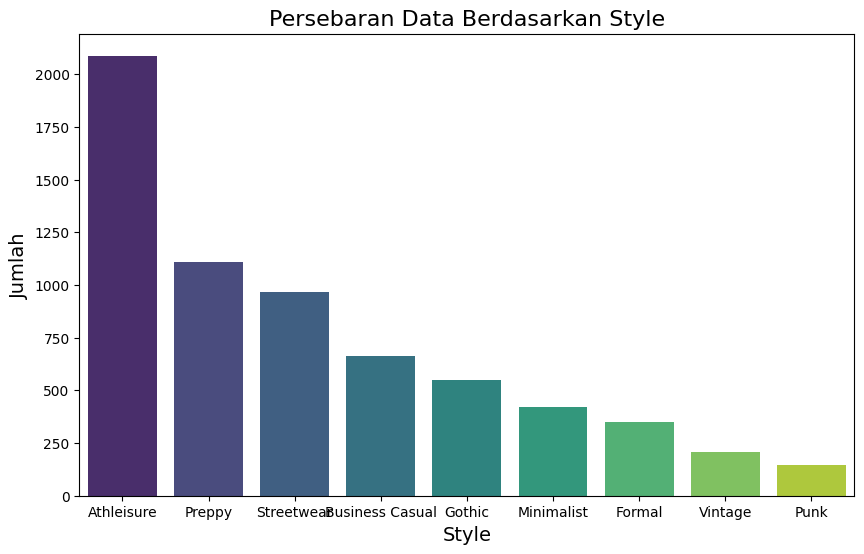

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Hitung jumlah setiap kategori di kolom 'style'
style_counts = data['style'].value_counts()

print(style_counts)

# Membuat diagram batang
plt.figure(figsize=(10, 6))
sns.barplot(x=style_counts.index, y=style_counts.values, palette='viridis')

# Tambahkan label dan judul
plt.title('Persebaran Data Berdasarkan Style', fontsize=16)
plt.xlabel('Style', fontsize=14)
plt.ylabel('Jumlah', fontsize=14)
plt.xticks(rotation=0)  
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)  # Normalisasi sesuai ResNet50
    return image

2024-12-11 03:12:26.877338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 03:12:26.877468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 03:12:27.042938: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from sklearn.preprocessing import LabelEncoder

# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Encode kolom target di dataset
data['style'] = label_encoder.fit_transform(data['style'])

# Lihat mapping dari label asli ke numerik
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Label mapping: {'Athleisure': 0, 'Business Casual': 1, 'Formal': 2, 'Gothic': 3, 'Minimalist': 4, 'Preppy': 5, 'Punk': 6, 'Streetwear': 7, 'Vintage': 8}


In [8]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# Dataset generator
def generate_dataset(data, image_col, target_col, batch_size=32):
    image_paths = data[image_col].values
    targets = data[target_col].values.astype('int')  # Pastikan target adalah integer (untuk klasifikasi)

    def generator():
        for image_path, target in zip(image_paths, targets):
            yield load_and_preprocess_image(image_path), target

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)  # Menggunakan dtype int64 untuk label (sparse)
        )
    )
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Tambahkan batching dan prefetch

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_dataset = generate_dataset(train_data, "image_path", "style")
val_dataset = generate_dataset(val_data, "image_path", "style")

# Ambil batch pertama untuk memeriksa bentuk dataset
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)  # Harus (batch_size, 224, 224, 3)
    print("Label batch shape:", labels.shape)  # Harus (batch_size,

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [9]:
train_batches = len(list(train_dataset))
val_batches = len(list(val_dataset))
print(f"Train batches: {train_batches}, Validation batches: {val_batches}")

Train batches: 163, Validation batches: 41


In [10]:
train_dataset = train_dataset.repeat()  # Mengulangi dataset untuk seluruh epoch
val_dataset = val_dataset.repeat()

In [11]:
# Periksa dimensi train_dataset
for images, labels in train_dataset.take(1):
    print("Image batch shape (train):", images.shape)
    print("Label batch shape (train):", labels.shape)

# Periksa dimensi val_dataset
for images, labels in val_dataset.take(1):
    print("Image batch shape (val):", images.shape)
    print("Label batch shape (val):", labels.shape)

Image batch shape (train): (32, 224, 224, 3)
Label batch shape (train): (32,)
Image batch shape (val): (32, 224, 224, 3)
Label batch shape (val): (32,)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.regularizers import l2

# Load ResNet50 model dengan weights ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer di base model
base_model.trainable = False

# Tambahkan layer tambahan
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(9, activation='softmax')(x)  # Output layer untuk 9 kelas

# Buat model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ringkasan model
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

 Trainable params: 558,601 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

In [15]:
from sklearn.utils.class_weight import compute_class_weight

train_size = 0.8 * len(data)
train_size = int(train_size)

y_train = data['style'].iloc[:train_size].values

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',     # Pantau validasi loss
    patience=5,             # Berhenti jika tidak ada peningkatan setelah 3 epoch
    restore_best_weights=True  # Kembalikan bobot terbaik setelah selesai
)

In [17]:
batch_size = 32
dataset_size = len(data)

steps_per_epoch = train_size // batch_size
validation_steps = (dataset_size - train_size) // batch_size

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

print("The training is done!")

Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.2711 - loss: 2.0942 - val_accuracy: 0.4969 - val_loss: 1.4108 - learning_rate: 0.0010
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.3966 - loss: 1.5502 - val_accuracy: 0.4937 - val_loss: 1.3670 - learning_rate: 0.0010
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.4484 - loss: 1.3796 - val_accuracy: 0.5229 - val_loss: 1.3130 - learning_rate: 0.0010
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.4945 - loss: 1.2558 - val_accuracy: 0.5355 - val_loss: 1.2885 - learning_rate: 0.0010
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 566s 4s/step - accuracy: 0.4977 - loss: 1.1852 - val_accuracy: 0.5434 - val_loss: 1.2195 - learning_rate: 0.0010
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.5247 - loss: 1.1162 - val_accuracy: 0.5710 - val_loss: 1.2073 - learning_rate: 0.0010
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.5422 - loss: 1.

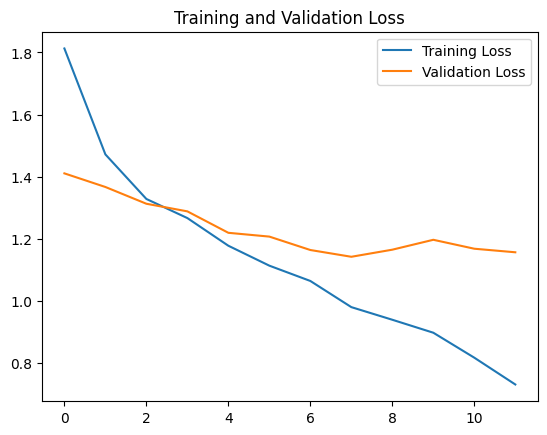

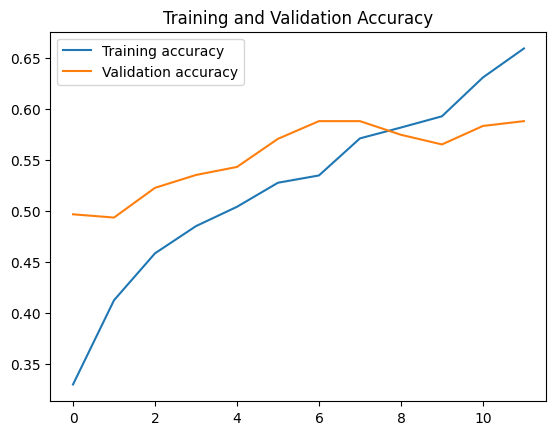

In [21]:
import matplotlib.pyplot as plt

# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Visualisasi loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [18]:
model.save("/kaggle/working/style.h5")
print("Model berhasil disimpan ke style.h5")

Model berhasil disimpan ke style.h5


In [19]:
from IPython.display import FileLink
FileLink(r'style.h5')

/kaggle/working/style.h5

In [22]:
from tensorflow.keras.models import load_model

# Memuat model dari file .h5
model = load_model("/kaggle/working/style.h5")

# Implementation

Di bawah ini merupakan program untuk mengekstrak fitur yang diperlukan untuk melakukan rekomendasi. Rekomendasi ini didasarkan pada dua fitur gambar: color group dan style. Color group dicari melalui ekstraksi warna menggunakan K-means untuk dicari value RGB-nya. Kemudian berdasarkan value tersebut, dengan menentukan rule tertentu, image outfit yang dimasukkan akan dikategorikan ke color group tertentu dari sembilan color group yang ada. Style dari outfit ditentukan dengan menggunakan model yang sudah dilatih sebelumnya. 

Setelah mendapatkan fitur color group dan style dari outfit masukan, selanjutnya akan dicari kategori outfit yang belum ada di list masukan pengguna. Kemudian, dicari pula yang sesuai dengan color group dan stylenya. Dari sekian banyaknya yang sesuai, akan dipilih satu item dari masing masing kategori yang belum ada pada masukan secara random. 

In [47]:
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from collections import Counter
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Load pre-trained style model
style_model = tf.keras.models.load_model("style.h5")

class_names = ['Athleisure', 'Business Casual', 'Formal', 'Gothic', 'Minimalist', 'Preppy', 'Punk', 'Streetwear', 'Vintage']

def extract_style_features(image_path):
    """
    Extracts style features from an image using a pre-trained model.

    Args:
        image_path (str): Path to the image file.

    Returns:
        np.ndarray: Extracted style feature vector.
    """
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    img_array = np.array(image) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Tambah dimensi batch
    
    predictions = style_model.predict(img_array)
    predicted_label_index = np.argmax(predictions) 
    predicted_style = class_names[predicted_label_index]
    return predicted_style

def extract_dominant_color(image_path, k=5):
    """
    Extracts the dominant color from an image using K-Means clustering.

    Args:
        image_path (str): Path to the image file.
        k (int): Number of clusters for K-Means.

    Returns:
        np.ndarray: Dominant color as an RGB array.
    """
    # Open the image and convert to RGB
    image = Image.open(image_path).convert("RGB")
    image = image.resize((150, 150))  # Resize gambar
    img_array = np.array(image)
    img_array = img_array.reshape((-1, 3))  # Reshape ke [n_pixels, 3]

    # Cluster colors using K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(img_array)
    colors = kmeans.cluster_centers_
    counts = Counter(kmeans.labels_)

    # Sort colors based on frequency
    sorted_colors = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    dominant_color = colors[sorted_colors[0][0]]
    return dominant_color

def rgb_to_hsv(rgb):
    """
    Converts an RGB color to HSV.

    Args:
        rgb (np.ndarray): RGB color array.

    Returns:
        tuple: HSV representation.
    """
    return mcolors.rgb_to_hsv(rgb / 255.0)

def assign_color_group(dominant_color):
    """
    Assigns a color group based on HSV values.

    Args:
        dominant_color (np.ndarray): Dominant RGB color.

    Returns:
        str: Color group name.
    """
    # Convert color to HSV
    dominant_hsv = rgb_to_hsv(dominant_color)

    h, s, v = dominant_hsv
    if s < 0.2 and v > 0.8:
        return "Neutral"
    elif s < 0.3 and v < 0.5:
        return "Dark"
    elif s < 0.4:
        return "Pastel"
    elif 0.1 <= h <= 0.2 and s > 0.3:
        return "Earth Tone"
    elif s > 0.7 and v > 0.5:
        return "Bright/Vivid"
    elif 0.9 <= h <= 1.0 or 0.0 <= h <= 0.1:
        return "Warm"
    elif 0.5 <= h <= 0.75:
        return "Cool"
    else:
        return "Other"


In [ ]:
def match_outfits_with_color_and_style(input_image_paths, annotations_df, input_categories):
    """
    Matches outfits based on both color group and style similarity and selects a random outfit for each category.

    Args:
        input_image_paths (list): List of image file paths.
        annotations_df (pd.DataFrame): DataFrame containing outfit annotations.
        input_categories (list): List of categories corresponding to each input image.

    Returns:
        dict: Recommended outfits grouped by category, with a random selection for each category.
    """

    input_features = []
    for img_path in input_image_paths:
        # Ekstrak style and color group untuk masing masing input image
        style_feature = extract_style_features(img_path)
        dominant_color = extract_dominant_color(img_path)
        color_group = assign_color_group(dominant_color)
        input_features.append((style_feature, color_group))

        # Debugging output
        print(f"Input Image: {img_path}")
        print(f"Style Feature: {style_feature}")
        print(f"Color Group: {color_group}")

    matching_outfits = {}

    for _, row in annotations_df.iterrows():
        row_category = row['category']
        row_style = row['style']
        row_color_group = row['color_group']
        
        if row_category in input_categories:
            continue
        
        for predicted_style, color_group in input_features:
            # Sesuaikan category, style, dan color group
            if row_style == predicted_style and row_color_group == color_group:
                if row_category not in matching_outfits:
                    matching_outfits[row_category] = []
                matching_outfits[row_category].append(row.to_dict())  # Konversi ke bentuk dictionary
                break 

    matching_outfits_list = []
    for category, outfits in matching_outfits.items():
        matching_outfits_list.extend(outfits)
    
    matching_outfits_df = pd.DataFrame(matching_outfits_list).drop_duplicates(subset=['image_path'])

    recommended_outfits = {}
    for category in annotations_df['category'].unique():
        if category in input_categories:
            continue
        outfits_of_type = matching_outfits_df[matching_outfits_df['category'] == category]
        if not outfits_of_type.empty:
            # Pilih random outfit dari matching_outfits
            random_outfit = outfits_of_type.sample(n=1)  # Secara random pilih satu outfit
            recommended_outfits[category] = random_outfit.to_dict('records')  # Result dibentuk ke dalam list
    
    return recommended_outfits


In [ ]:
# Fungsi untuk menampilkan gambar menggunakan matplotlib
def show_image(image_path, title="Image"):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Menonaktifkan sumbu
    plt.show()

# Fungsi untuk menampilkan input dan rekomendasi
def display_input_and_recommendations(input_image_paths, matching_outfits):
    # Menampilkan gambar inputan user
    print(f"Displaying input images: {input_image_paths}")
    for input_image_path in input_image_paths:
        show_image(input_image_path, title="Input Image")

    # Menampilkan hasil rekomendasi
    if matching_outfits:
        print("Displaying recommended outfits:")
        
        # Iterasi setiap kategori (e.g., 'footwear', 'bag', 'hat') di matching_outfits dictionary
        for category, outfits in matching_outfits.items():
            for i, outfit in enumerate(outfits, 1):  # Iterasi list dari outfits di category
                print(f"Recommending {category}: {outfit['image_path']}")
                show_image(outfit['image_path'], title=f"Recommended {category.capitalize()} {i}")
    else:
        print("No matching outfits found.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Input Image: /kaggle/input/fashionoutfititems/outfit_items_dataset/upperwear/tshirt/upperwear_tshirt10010.png
Style Feature: Minimalist
Color Group: Dark
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Input Image: /kaggle/input/fashionoutfititems/outfit_items_dataset/bottomwear/pants/bottomwear_pants1005.png
Style Feature: Minimalist
Color Group: Neutral
Displaying input images: ['/kaggle/input/fashionoutfititems/outfit_items_dataset/upperwear/tshirt/upperwear_tshirt10010.png', '/kaggle/input/fashionoutfititems/outfit_items_dataset/bottomwear/pants/bottomwear_pants1005.png']


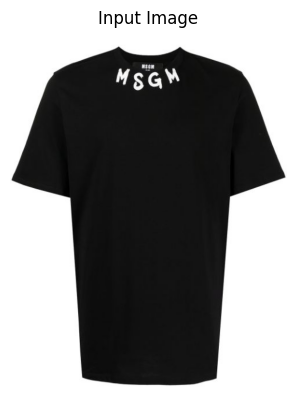

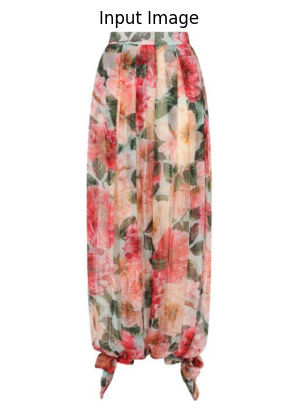

Displaying recommended outfits:
Recommending footwear: /kaggle/input/fashionoutfititems/outfit_items_dataset/footwear/heels/footwear_heels3956.png


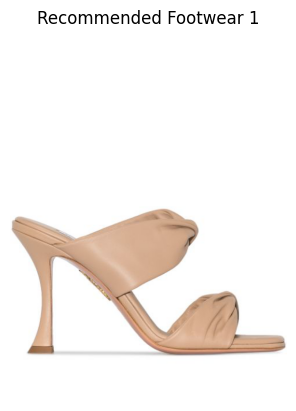

Recommending bag: /kaggle/input/fashionoutfititems/outfit_items_dataset/accessories/bag/accessories_bag14064.png


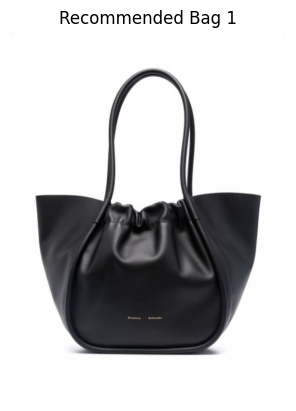

Recommending hat: /kaggle/input/fashionoutfititems/outfit_items_dataset/accessories/hat/accessories_hat1343.png


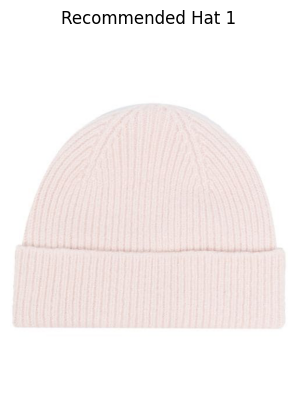

In [ ]:
# Example Usage
if __name__ == "__main__":
    # Load annotations DataFrame
    annotations_df = pd.read_csv('/kaggle/input/outfitsatribute/outfits-attributes.csv')
    
    # Menentukan inputan dan juga kategorinya
    input_image_paths = [
        '/kaggle/input/fashionoutfititems/outfit_items_dataset/upperwear/tshirt/upperwear_tshirt10010.png',
        '/kaggle/input/fashionoutfititems/outfit_items_dataset/bottomwear/pants/bottomwear_pants1005.png',
    ]
    input_categories = [
        'upperwear',
        'bottomwear',
    ]
    
    # Pastikan gambar yang diinputkan tidak lebih dari 5 outfit
    if len(input_image_paths) > 5:
        raise ValueError("Please provide up to 5 input images.")
    
    # Pasangkan outfit berdasarkan inputan
    recommended_outfits = match_outfits_with_color_and_style(input_image_paths, annotations_df, input_categories)
    
    # Perlihatkan hasil rekomendasi
    if recommended_outfits:
        display_input_and_recommendations(input_image_paths, recommended_outfits)

    else:
        print("No matching outfits found.")